Welcome! This is a tutorial about RASpy (Reaction Activity Scores in Python). 
In this notebook, we will show how to pre-process a raw count matrix before RAS computation.

## Load the data

Load the count matrix (h5ad format). Such a dataset are reported as raw count and was downloaded from the  GEO database Atlas (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE110949). 

In [3]:
import scanpy as sc
adata=sc.read_h5ad("../datasets/GSE110949_raw_adata")
adata

AnnData object with n_obs × n_vars = 2000 × 19826
    obs: 'type'

## Processing on the count data

Annotate all the mithocondrial genes

In [4]:
#in case of gene-symbol annotation for genes
adata.var['mt'] =adata.var_names.str.startswith('MT-')   

In [5]:
#in case of ENSG annotation for genes
#import pandas as pd
#mito_ensembl_ids=pd.read_csv("../utils_files/mitocondrial_genes.csv",index_col=0)
#mito_genes=mito_ensembl_ids['ensembl_gene_id'].values
#adata.var['mt'] = [True if name in mito_genes else False for name in adata.var_names]

Compute quality metrics

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Visualize some of the computed quality measures with violin plots

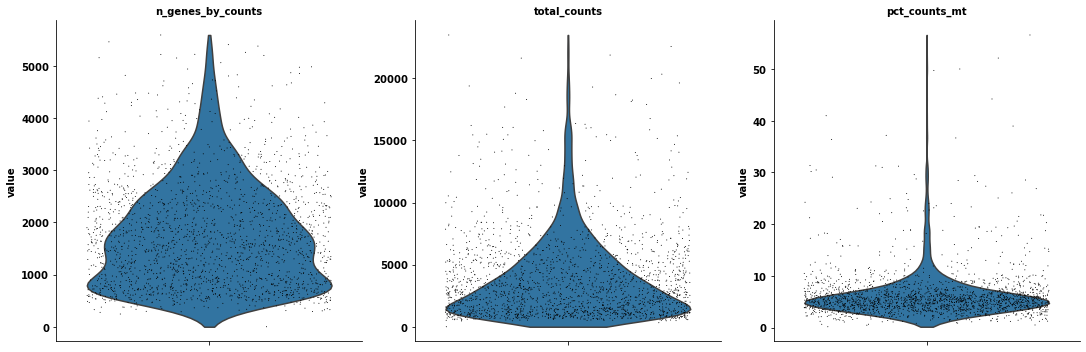

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_mt'],jitter=0.4, multi_panel=True)

Basic filtering: 
- exclude low-quality cells with fewer expressed (!=0) genes 
- exclude all genes that were not detected in at least three cells
- exclude cells with too many mitochondrial genes expressed
- exclude cells with too many total counts


In [8]:
sc.pp.filter_cells(adata, min_genes=2000)
sc.pp.filter_genes(adata, min_cells=3)

adata =adata[adata.obs.total_counts <= 15000, :]  
adata = adata[adata.obs.pct_counts_mt < 10, :]  

adata

View of AnnData object with n_obs × n_vars = 651 × 14730
    obs: 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

Trying to set attribute `.obs` of view, copying.


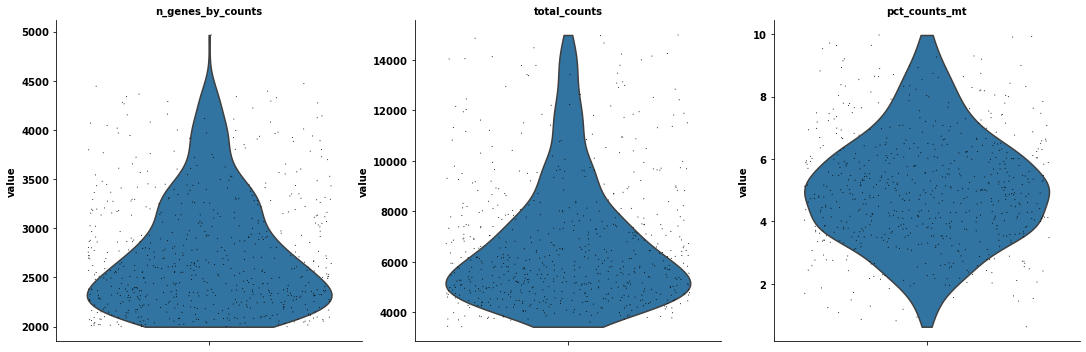

In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Annotate cell cycle

Suppose that you want to annotate the cell cycle of each cell to be removed during the clustering of RAS (see notebook "RAS cluster analysis")

In [10]:
adata_for_cellcycle=adata.copy()

Applying of Normalization, Log-transformation and scaling to prepare data for cell cycle scoring

In [11]:
#sc.pp.normalize_per_cell(adata_for_cellcycle, counts_per_cell_after=1e4)
sc.pp.log1p(adata_for_cellcycle)
sc.pp.scale(adata_for_cellcycle)

Load cell cycle genes defined in Tirosh et al, 2015. It is a list of 97 genes, represented by their gene symbol. The list here is for humans.

In [12]:
#in case of gene-symbol annotation for genes
cell_cycle_genes = [x.strip() for x in open('../utils_files/regev_lab_cell_cycle_genes_symbol.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [13]:
#in case of ENSG annotation for genes
#cell_cycle_genes = [x.strip() for x in open('../utils_files/regev_lab_cell_cycle_genes_ensg.txt')]
#s_genes = cell_cycle_genes[:42]
#g2m_genes = cell_cycle_genes[42:]

Filter out genes not in the data

In [14]:
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes =[x for x in g2m_genes if x in adata.var_names]

Perform cell cycle scoring

In [15]:
sc.tl.score_genes_cell_cycle(adata_for_cellcycle, s_genes=s_genes, g2m_genes=g2m_genes)

In [16]:
adata_for_cellcycle

AnnData object with n_obs × n_vars = 651 × 14730
    obs: 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

Save the information about the cell cycle on the original adata count matrix 

In [17]:
adata.obs['phase']=adata_for_cellcycle.obs['phase']
adata.obs['S_score']=adata_for_cellcycle.obs['S_score']
adata.obs['G2M_score']=adata_for_cellcycle.obs['G2M_score']

## Save the count matrix

In [18]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

Save the count matrix preprocessed for RAS computation

In [19]:
#adata.write("../datasets/GSE110949_gene_adata")
#adata